In [27]:
import os
import ast
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

In [28]:
os.listdir("data")

['hasil_teks_preprocessing.csv']

In [29]:
df = pd.read_csv(os.path.join("data","hasil_teks_preprocessing.csv"))
df.head()

,Kelas,teks_stemming
0,Kabar Insan Oke,"['rabu', 'kemarin', 'balai', 'diklat', 'indust..."
1,Inbis Tohpati,"['webinar', 'digital', 'tourism', 'bdi', 'denp..."
2,Diklat 3 in 1,"['diklat', 'in', 'buat', 'gerak', 'animasi', '..."
3,Inbis Tohpati,"['startup', 'bootcamp', 'and', 'final', 'pitch..."
4,Bikin Maker Space,"['kepala', 'bdi', 'denpasar', 'zya', 'labiba',..."


In [30]:
df.groupby("Kelas").size()

Kelas
Agenda                44
Bikin Maker Space     13
Diklat 3 in 1         53
Inbis Tohpati         40
Kabar Insan Oke      103
Teaching Factory      10
pengumuman            61
dtype: int64

In [31]:
feature = [" ".join(pd.eval(i)) for i in df['teks_stemming']]
target = df["Kelas"].values

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(feature).toarray()
tf = pd.DataFrame(X,columns=vectorizer.get_feature_names_out()).T
tf

,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
abdi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
academy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acceleration,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aceh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
achmad,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youtube,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
zaman,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zona,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zoom,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
c = (tf==0).astype(int).sum(axis=1)
b = (tf!=0).astype(int).sum(axis=1)
tf_rf = pd.concat([c, b], axis=1)
tf_rf.columns = ["c","b"]
tf_rf["RF"] =np.log2(2 + (tf_rf["b"]/tf_rf["c"]))
tf_rf

,c,b,RF
abdi,323,1,1.002232
academy,322,2,1.004473
acceleration,322,2,1.004473
aceh,323,1,1.002232
achmad,323,1,1.002232
...,...,...,...
youtube,320,4,1.008989
zaman,321,3,1.006726
zona,311,13,1.029842
zoom,308,16,1.036994


In [34]:
kelas = sorted(df["Kelas"].unique())
kelas

['Agenda',
 'Bikin Maker Space',
 'Diklat 3 in 1',
 'Inbis Tohpati',
 'Kabar Insan Oke ',
 'Teaching Factory',
 'pengumuman']

In [35]:
from math import log
tf_abs = pd.DataFrame(np.zeros((len(tf),4)),index=tf.index).astype(int)
for i in kelas:
    dt = pd.concat([
        (tf[df[df["Kelas"]==i].index.tolist()]==0).astype(int).sum(axis=1),
        (tf[df[df["Kelas"]!=i].index.tolist()]==0).astype(int).sum(axis=1),
        (tf[df[df["Kelas"]==i].index.tolist()]!=0).astype(int).sum(axis=1),
        (tf[df[df["Kelas"]!=i].index.tolist()]!=0).astype(int).sum(axis=1)
    ], axis=1)
    tf_abs = tf_abs + dt
tf_abs.columns = ["Nkj","N~kj","Nk~j","N~k~j"]
tf_abs["ABS"] = abs(np.log(((tf_abs["Nkj"] + 0.5)*(tf_abs["N~k~j"] + 0.5))/((tf_abs["N~kj"] + 0.5)*(tf_abs["Nk~j"] + 0.5))))
tf_abs

,Nkj,N~kj,Nk~j,N~k~j,ABS
abdi,323,1938,1,6,0.324134
academy,322,1932,2,12,0.181029
acceleration,322,1932,2,12,0.181029
aceh,323,1938,1,6,0.324134
achmad,323,1938,1,6,0.324134
...,...,...,...,...,...
youtube,320,1920,4,24,0.095863
zaman,321,1926,3,18,0.125455
zona,311,1866,13,78,0.030012
zoom,308,1848,16,96,0.024225


In [36]:
rf_res = []
for i in range(len(tf)):
    rf_res.append(tf.values[i] * tf_rf["RF"].values[i])
rf_res = np.array(rf_res)
rf_res = pd.DataFrame(rf_res,columns=tf.columns,index=tf.index).T
# rf_res = pd.set_option('display.max_columns', 10)
rf_res

,abdi,academy,acceleration,aceh,achmad,adaptasi,administrator,adu,agam,agama,...,yangsudah,yayasan,yedi,yogyakarta,youth,youtube,zaman,zona,zoom,zya
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.036994,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.029842,0.000000,1.046693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.192391,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [37]:
abs_res = []
for i in range(len(tf)):
    abs_res.append(tf.values[i] * tf_abs["ABS"].values[i])
abs_res = np.array(abs_res)
abs_res = pd.DataFrame(abs_res,columns=tf.columns,index=tf.index).T
# abs_res = pd.set_option('display.max_columns', 8)
abs_res

,abdi,academy,acceleration,aceh,achmad,adaptasi,administrator,adu,agam,agama,...,yangsudah,yayasan,yedi,yogyakarta,youth,youtube,zaman,zona,zoom,zya
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.024225,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.030012,0.000000,0.019165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.041598,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [38]:
Xrf = rf_res.values
Xabs = abs_res.values
le = LabelEncoder()
y = le.fit_transform(target)
le.classes_

array(['Agenda', 'Bikin Maker Space', 'Diklat 3 in 1', 'Inbis Tohpati',
       'Kabar Insan Oke ', 'Teaching Factory', 'pengumuman'], dtype=object)

In [39]:
smr = SMOTE(k_neighbors=3, random_state=42)
Xresr,yresr = smr.fit_resample(Xrf,y)

sma = SMOTE(k_neighbors=3, random_state=42)
Xresa,yresa = sma.fit_resample(Xabs,y)

In [40]:
xtrainr, xtestr, ytrainr, ytestr = train_test_split(Xresr,yresr,test_size=0.1,random_state=0)
xtraina, xtesta, ytraina, ytesta = train_test_split(Xresa,yresa,test_size=0.1,random_state=0)

In [41]:
# from sklearn.model_selection import cross_val_score
# k_range = range(3, 31)
# k_scores = []

# for k in k_range:
#     knn_rf = KNeighborsClassifier(n_neighbors= k, metric="cosine")
#     scores = cross_val_score(knn_rf, Xrf, y , cv = 5, scoring= 'accuracy')
#     k_scores.append(scores.mean())
# k_scores

In [42]:
# k_range = range(3, 31)
# k_scores = []

# for k in k_range:
#     knn_abs = KNeighborsClassifier(n_neighbors= k, metric="cosine")
#     scores = cross_val_score(knn_abs, Xabs, y , cv = 5, scoring= 'accuracy')
#     k_scores.append(scores.mean())
# k_scores

In [43]:
k_range = list(range(7, 10))
param_grid = dict(n_neighbors=k_range)

knn_rf = KNeighborsClassifier(n_neighbors=k_range, metric = "cosine")
clf_rf = GridSearchCV(knn_rf, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
result_rf = clf_rf.fit(xtrainr, ytrainr)

knn_abs = KNeighborsClassifier(n_neighbors=k_range, metric = "cosine")
clf_abs = GridSearchCV(knn_abs, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
result_abs = clf_abs.fit(xtraina, ytraina)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [44]:
pd.DataFrame(clf_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007923,4.938355e-03,0.064883,0.011082,7,{'n_neighbors': 7},0.623077,0.600000,0.623077,0.565891,0.550388,0.592487,0.029690,2
1,0.010881,3.923238e-03,0.063318,0.006043,8,{'n_neighbors': 8},0.630769,0.553846,0.607692,0.596899,0.573643,0.592570,0.026700,1
2,0.007999,8.792443e-07,0.081544,0.027898,9,{'n_neighbors': 9},0.623077,0.576923,0.607692,0.589147,0.550388,0.589445,0.025086,3


In [45]:
pd.DataFrame(clf_abs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007858,0.006996,0.056593,0.005426,7,{'n_neighbors': 7},0.607692,0.615385,0.584615,0.612403,0.604651,0.604949,0.010822,1
1,0.009524,0.005908,0.101699,0.036930,8,{'n_neighbors': 8},0.600000,0.584615,0.584615,0.612403,0.581395,0.592606,0.011832,2
2,0.011203,0.003918,0.095681,0.015532,9,{'n_neighbors': 9},0.615385,0.592308,0.607692,0.581395,0.558140,0.590984,0.020234,3


In [46]:
pred_rf = clf_rf.predict(xtestr)

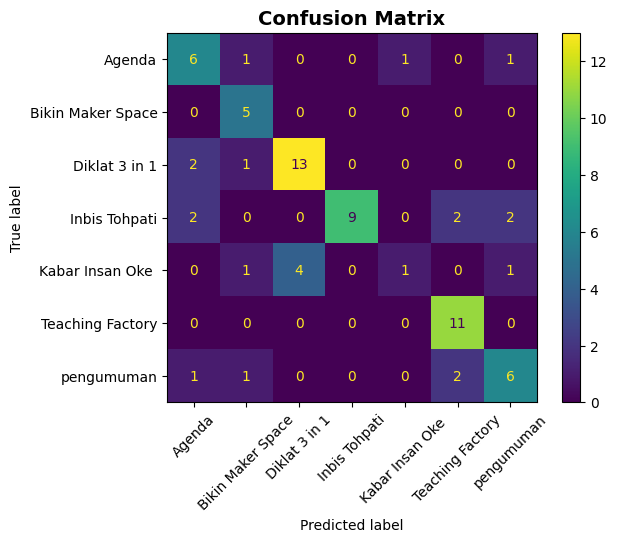


=======================Classification Report======================
================Term Frequency-Relevance Frequency================

                   precision    recall  f1-score   support

           Agenda       0.55      0.67      0.60         9
Bikin Maker Space       0.56      1.00      0.71         5
    Diklat 3 in 1       0.76      0.81      0.79        16
    Inbis Tohpati       1.00      0.60      0.75        15
 Kabar Insan Oke        0.50      0.14      0.22         7
 Teaching Factory       0.73      1.00      0.85        11
       pengumuman       0.60      0.60      0.60        10

         accuracy                           0.70        73
        macro avg       0.67      0.69      0.65        73
     weighted avg       0.72      0.70      0.68        73





In [47]:
cmr = confusion_matrix(ytestr, pred_rf)
dispr = ConfusionMatrixDisplay(confusion_matrix=cmr, display_labels=le.classes_)
dispr.plot()
plt.grid(False)
plt.title("Confusion Matrix", fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.show()

print()
print("=======================Classification Report======================")
print("================Term Frequency-Relevance Frequency================")
print()
print(classification_report(ytestr,pred_rf,target_names=le.classes_))
print()
print()

In [48]:
from sklearn import metrics
print (metrics.accuracy_score(ytestr, pred_rf))

0.6986301369863014


In [49]:
pred_abs = clf_abs.predict(xtesta)

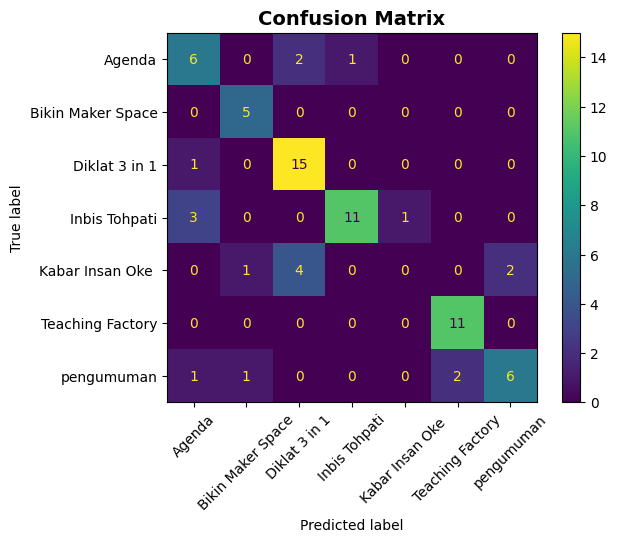


=================Classification Report=================
================Term Frequency-Absolute================

                   precision    recall  f1-score   support

           Agenda       0.55      0.67      0.60         9
Bikin Maker Space       0.71      1.00      0.83         5
    Diklat 3 in 1       0.71      0.94      0.81        16
    Inbis Tohpati       0.92      0.73      0.81        15
 Kabar Insan Oke        0.00      0.00      0.00         7
 Teaching Factory       0.85      1.00      0.92        11
       pengumuman       0.75      0.60      0.67        10

         accuracy                           0.74        73
        macro avg       0.64      0.71      0.66        73
     weighted avg       0.69      0.74      0.71        73





In [50]:
cma = confusion_matrix(ytesta, pred_abs)
dispa = ConfusionMatrixDisplay(confusion_matrix=cma, display_labels=le.classes_)
dispa.plot()
plt.grid(False)
plt.title("Confusion Matrix", fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.show()

print()
print("=================Classification Report=================")
print("================Term Frequency-Absolute================")
print()
print(classification_report(ytesta,pred_abs,target_names=le.classes_))
print() 
print()

In [51]:
print (metrics.accuracy_score(ytesta, pred_abs))

0.7397260273972602
